\newpage

## DSS Installation as a Docker Container ##

https://github.com/jupyter/docker-stacks  
https://hub.docker.com/r/jupyter/r-notebook/tags/  

_(optional) docker pull jupyter/r-notebook:latest_  

We want to make the DDS Prototype ~/analysis/ directory linked to the Juypter container. Use the following to mount the analysis directory (i.e. current working directory) as a volume in the Juypter container. Note that the directory needed to be added via the Docker Desktop Dashboard on Mac.

_docker run -it --rm -d -p 10000:8888 -v ${PWD}:/home/jovyan/work --name notebook jupyter/r-notebook:latest_  

To find the token from the container:  
_docker exec -it notebook jupyter server list_

Navigate to the container UI and enter the token:
http://localhost:10000

## DSS System Context ##

Figure 1 depicts the context for the DSS. The DSS operator interacts with the DSS Prototype for decision assitance. The DSS relies on a aircraft database to gather real-time flight data to review in decision support algorithms.

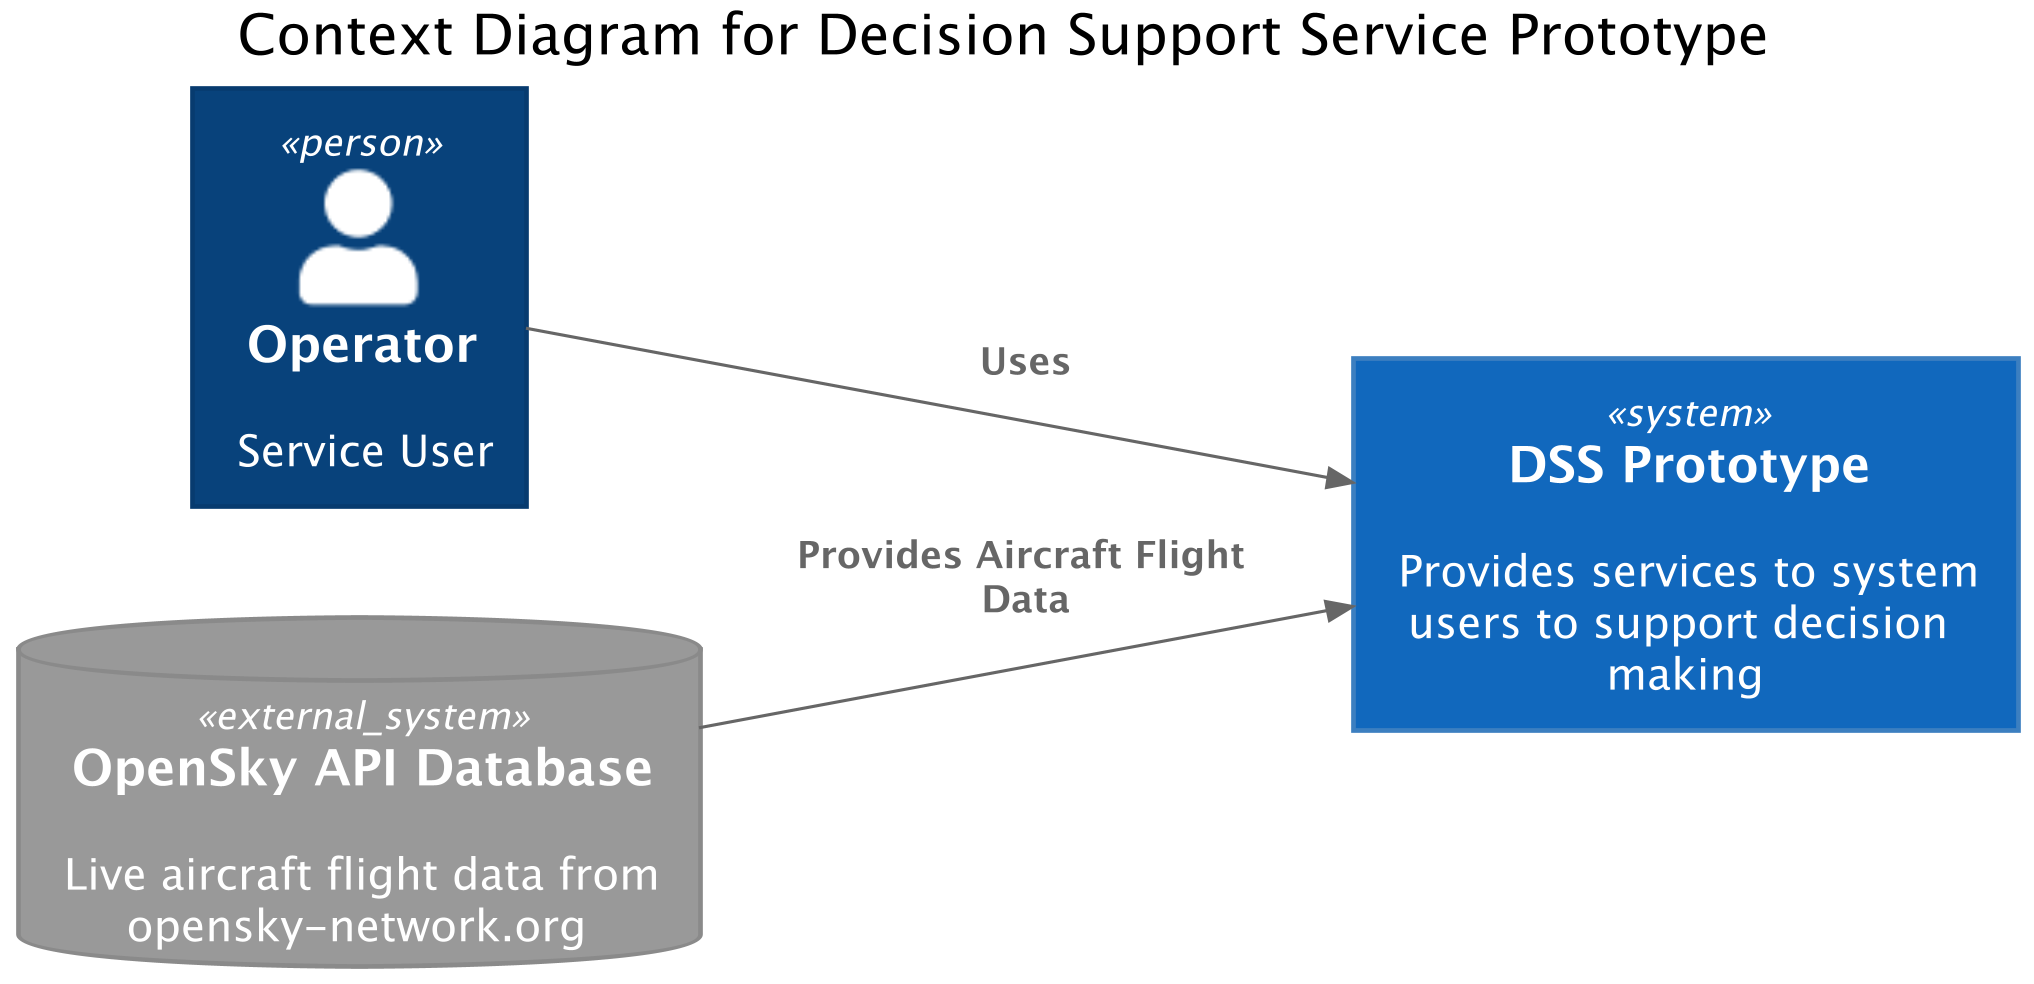

### DSS Container Architecture ###

Nine containers are instantiated as part of the DSS architecuture (see Figure 2). Six provide the DSS implementation while the additional 3 support collection and calculation of metrics. Each application container was designed around the 12-Factor Application "Single Responsibility Principle"; e.g. each app has one purpose to enable rapid insertion of new capabilities with low cohesion to other functionality. At this time, all responses are canned without underlying calculation to focus on meeting the 500 ms hypothesis pryor to burdening the application with calculation latency.

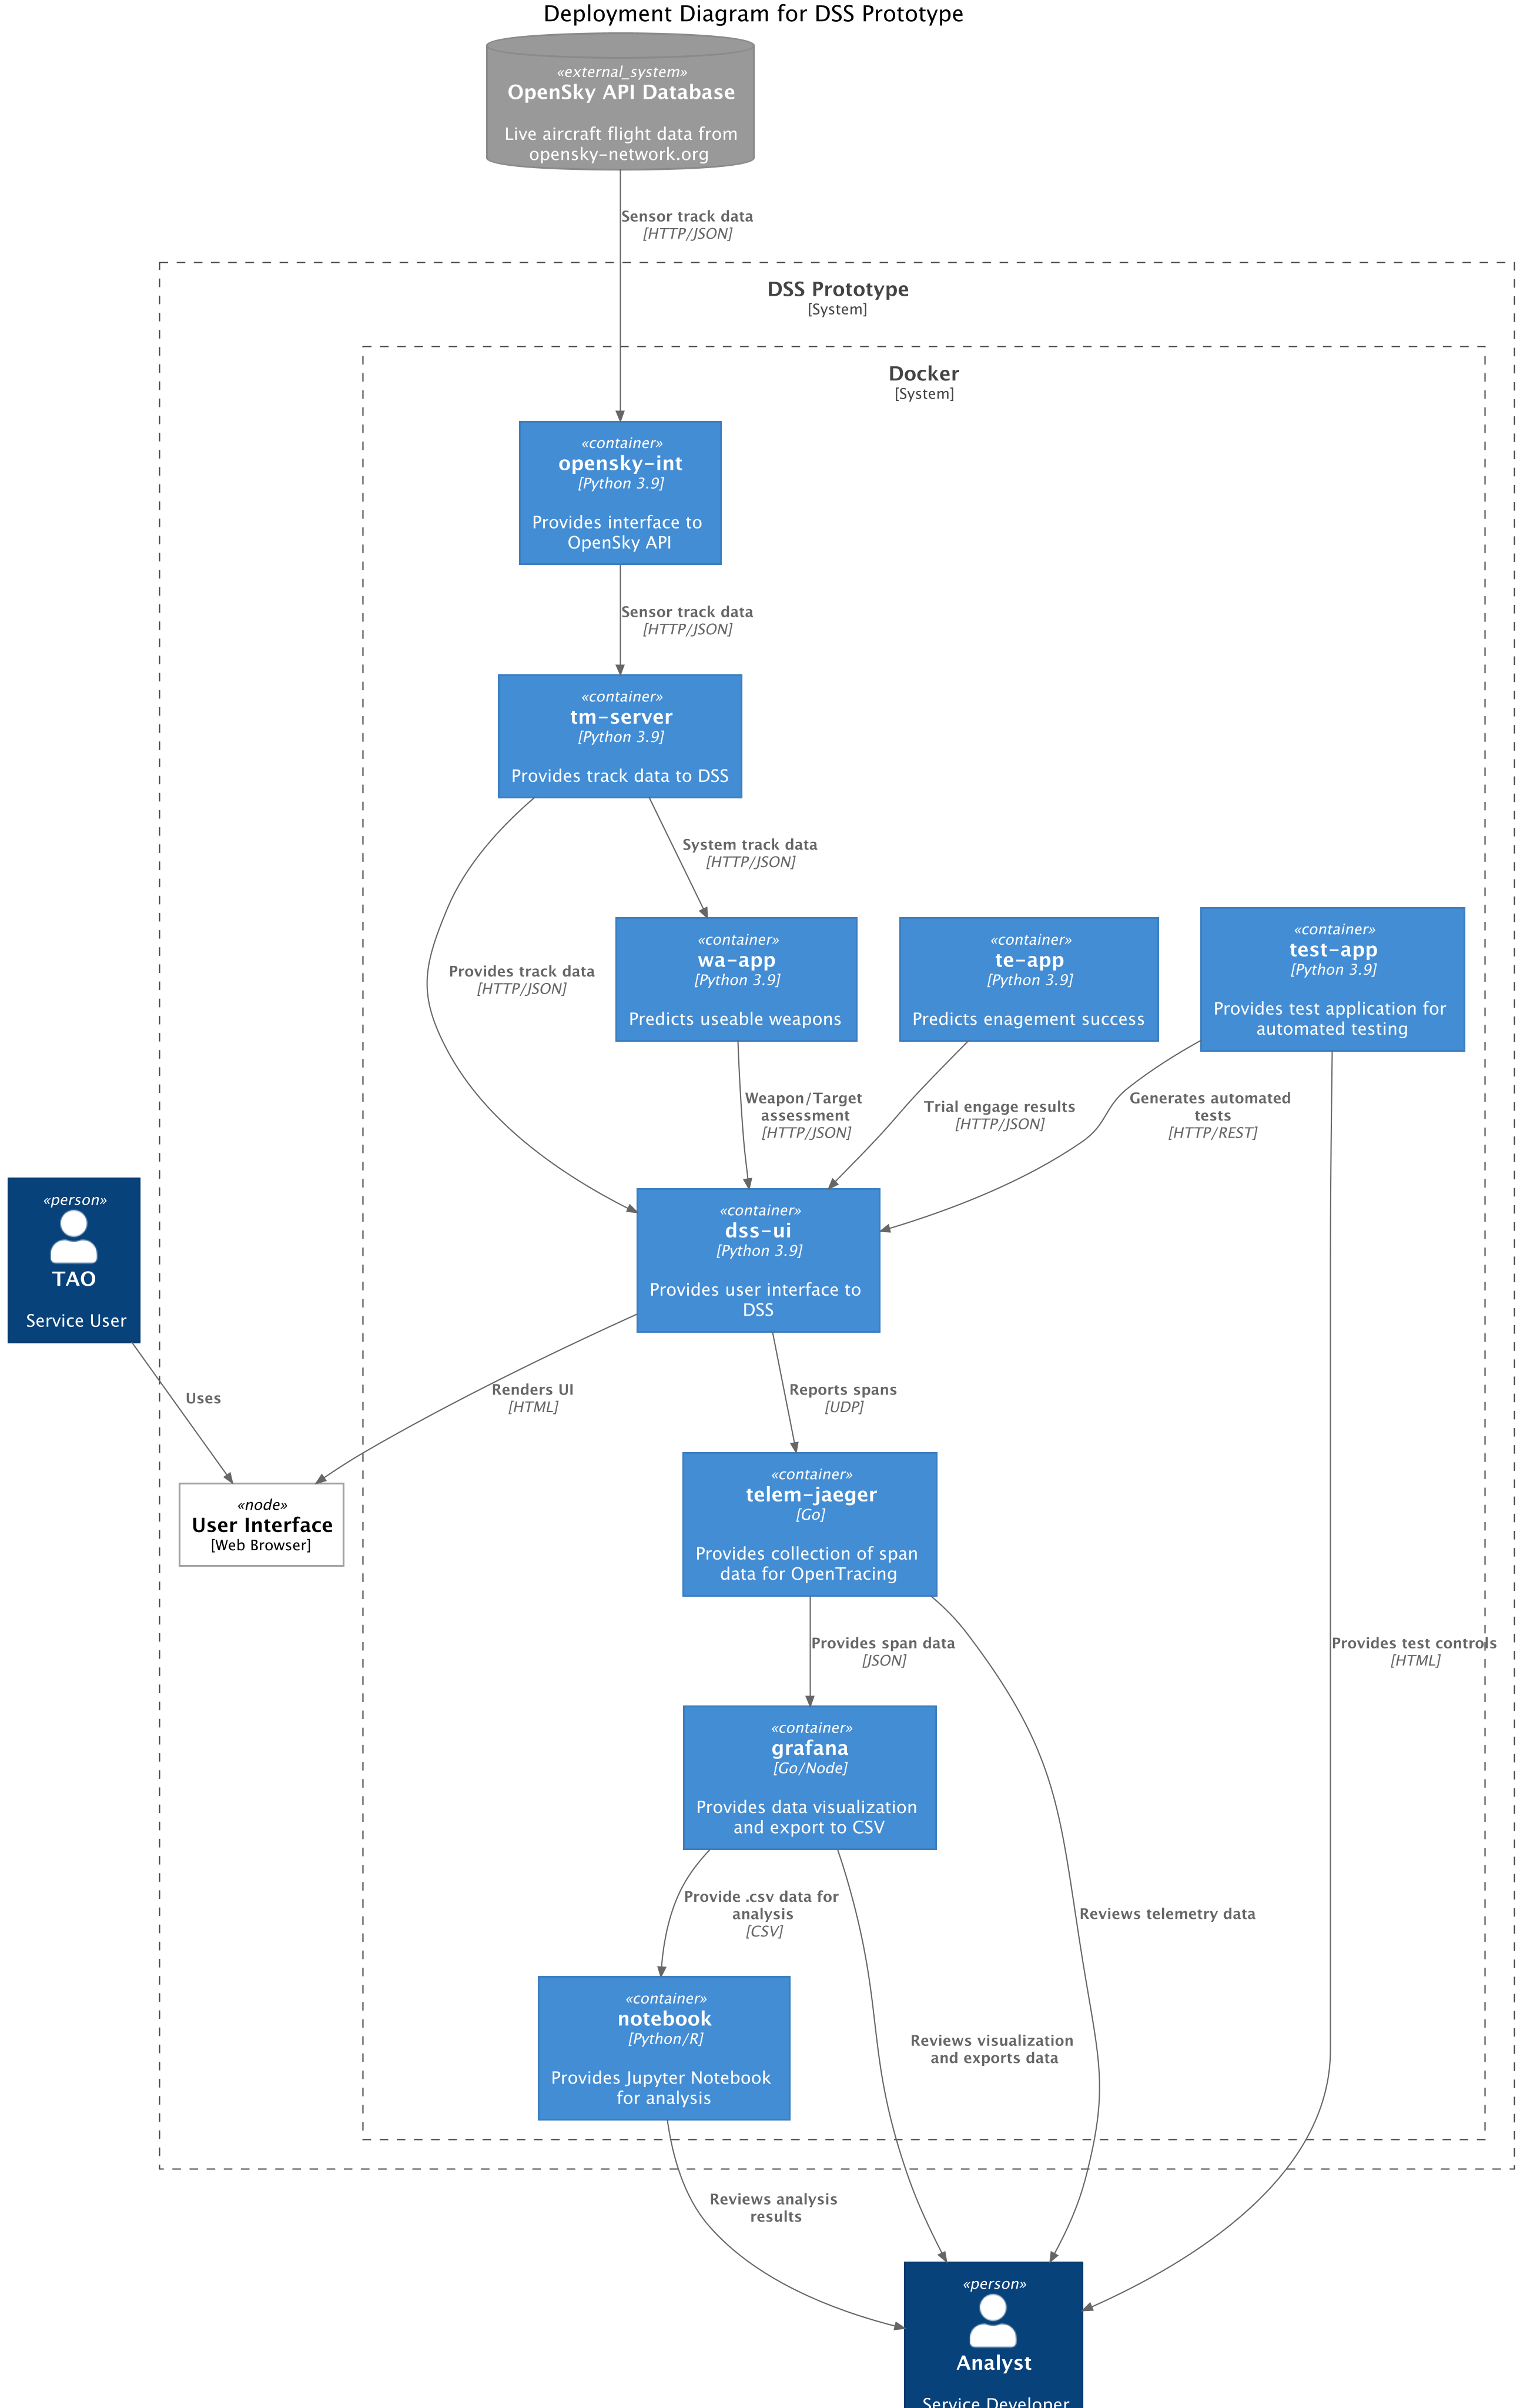

#### DSS Applications ####

- opensky-int: Provides the OpenSky API for flight data. The app provides data about aircraft within 60 NM of Richmond (RIC) or Dulles (IAD) airports.
- tm-server: Provides sensor track data (e.g. OpenSky) and system tracks to support DSS services. System tracks represents the system-wide common understand of a track objects state for decisions.
- wa-app: The Weapon Assessment Application determines which weapons are capable to successfully engage a target. The wa-app use the tm-server api to get track data.
- te-app: The Trail Engage Application determines the success rate of an engagement with a specific weapon target pairing. The predicted track kinematic data at engagement time is provided; therefore, the current track kinematics from the tm-server are not queried prior to providing a response.
- test-app: Provides and ability to generate automated test. the test-app uses the dss-ui to call dss-ui endpoint to replicate operator interactions with the DSS Prototype.
- dss-ui: Provides a simple graphical interface to launch DSS services.

#### DSS Tools ####

- telem-jaeger: The open source Jaeger containter collects "span" data from the DSS applications. Spans collection duration data for service call to over container; e.g. latency. This the fundamental data that is being analysed here.
- grafana: The open source Grafana container connects to the telem-jaeger container to create visualization dashboard. Also, Grafana faciliates the export of data as a .csv file for analysis.
- notebook: The Jupyter Notebook container support analysis of the data exported by Grafana. It is the core datafile use by this tool.

<!-- 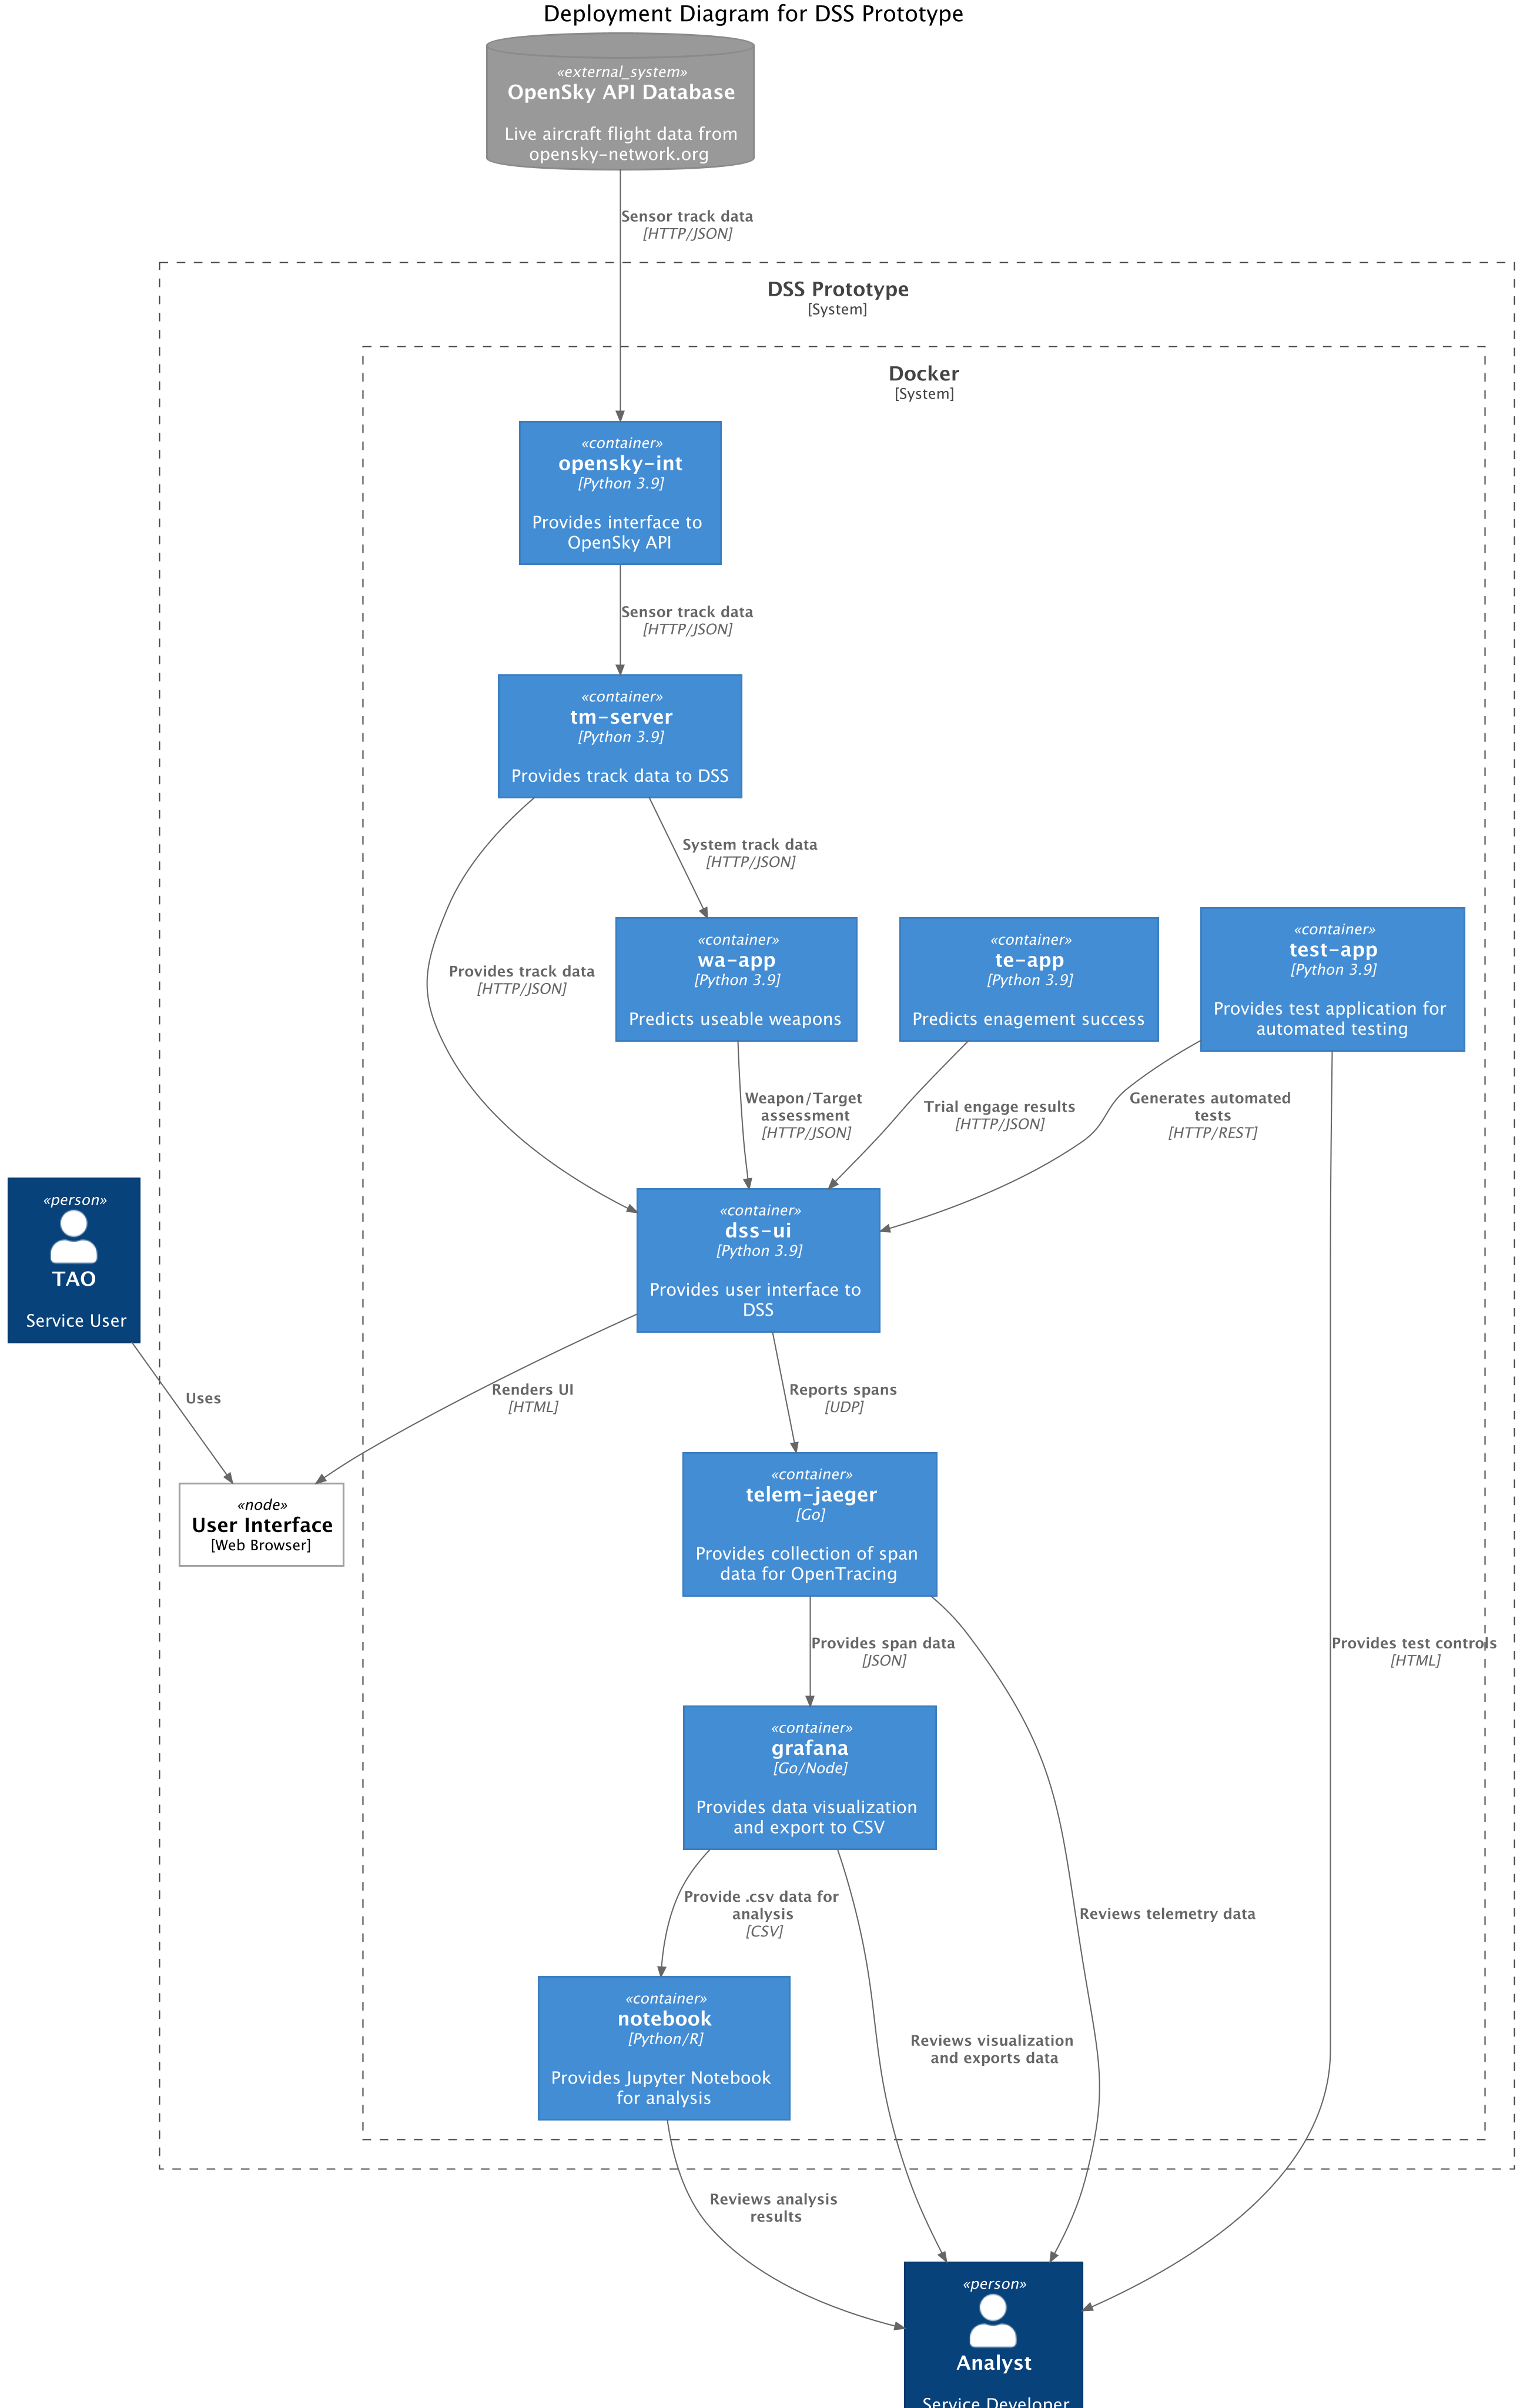 -->

### Hypothesis ###

Hypotheses are "innocent until proven guilty." We'll assume that SpaceX and others have proven that DevSecOps tech can meet hard-real-time requirements but nothing available in the body of knowledge documents this.

**Hypothesis:** Modern DevSecOps architectures can be designed to meet hard-real-time latency ($\mu$) requirements using modern computing environments and computing infrastructure.

$H_0: \mu \le 500  ms$ with jitter within latency bounds   
$H_a: \mu > 500  ms$ with jitter exceeding latency bounds  


_Murphy, Alvin C. and Moreland Jr, James D. ‘Integrating AI Microservices into Hard-Real-Time SoS to Ensure Trustworthiness of Digital Enterprise Using Mission Engineering’. 1 Jan. 2021 : 38 – 54._

In [1]:
options(warn=-1)

In [2]:
install.packages("stringr")                # Install packages and libraries in R
library("stringr", quietly = T)                       

install.packages("dplyr")
library("dplyr", quietly = T)

install.packages("ggplot2") 
install.packages("GGally")
library("ggplot2", quietly = T)                     
library("GGally", quietly = T)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘reshape’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [3]:
setwd('/home/jovyan/work/data')

In [4]:
options(warn=-1)
spanData <- read.csv('DSS_SpanData-linux-2022-05-17 16_39_29-setting10-5-1.csv', header = TRUE)
attach(spanData)

## Exploratory Data Analysis ##

In [5]:
summary(spanData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [6]:
head(spanData[, c(1,2)])
head(spanData[, c(3,4)])

,Trace.ID,Trace.name
,<chr>,<chr>
1,ace37850cdb7b1cee392815abdc8bba6,dss-prototype: /TE
2,18e77afd2f8b0da34c6e4481b6f3a743,dss-prototype: /tracks
3,d2ee862a28a26ebee5bbddcb7fa99d4d,dss-prototype: /IAD
4,4a106d80e3bb17eea14f95619d4ee887,dss-prototype: /RIC
5,8154babb571dacc56a5b27587ae75d44,dss-prototype: /WA
6,ec0af1182b87a7966ef8e0ccfc139e42,dss-prototype: /TE


,Start.time,Duration
,<chr>,<chr>
1,2022-05-17 16:39:04.983,6.59 ms
2,2022-05-17 16:39:03.975,4.49 ms
3,2022-05-17 16:39:02.589,382 ms
4,2022-05-17 16:39:00.840,745 ms
5,2022-05-17 16:38:59.827,9.40 ms
6,2022-05-17 16:38:58.817,6.33 ms


### Convert Data into Useable Metrics ###

To make the data more usable and easier to understand well apply conversions from text to numeric and add additional columns with supporting information. A **useCase** column is added to identify specific request use cases; e.g. Get Dulles Airport Data. The data also indicates whether the request is managed internally or a connection to an external service is required to provided a response (i.e., https://opensky-network.org).  A **numContainers** column is added to indicate the number of containers involved in providing a use case response (e.g. independent variable). An **extNetworkHops** column is added to include network hops for external request as an additional independent variable.

In [7]:
## Dictionary for converting data

DSSoperations <- c(
    "dss-prototype: /IAD" = "Get Dulles Airport Data (External)",
    "dss-prototype: /RIC" = "Get Richmond Airport Data (External)",
    "dss-prototype: /tracks" = "Get Stored Local DSS Tracks (Internal)",
    "dss-prototype: /TE" = "Trial Engage (Internal)",
    "dss-prototype: /WA" = "Assess Weapons (Internal)"
)

DSSnumContainers <- c(
    "dss-prototype: /IAD" = 3,
    "dss-prototype: /RIC" = 3,
    "dss-prototype: /tracks" = 2,
    "dss-prototype: /TE" = 2,
    "dss-prototype: /WA" = 3
)

# Used docker run -it --rm gophernet/traceroute opensky-network.org
# to determine hops from Docker network to OpenSky -- number may change in different environments

DSStraceRoute <- c(
    "dss-prototype: /IAD" = 14,
    "dss-prototype: /RIC" = 14,
    "dss-prototype: /tracks" = 0,
    "dss-prototype: /TE" = 0,
    "dss-prototype: /WA" = 0
)

In [8]:
# Convert character data into numeric metrics

spanMetrics <- spanData

# spanMetrics = cbind(spanMetrics, operation, containers)

for(i in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Add operation and container data
    spanMetrics$useCase = DSSoperations[Trace.name]
    spanMetrics$numContainers = DSSnumContainers[Trace.name]
    spanMetrics$extNetworkHops = DSStraceRoute[Trace.name]
    
    # truncate span ID
    spanMetrics$Trace.ID = str_sub(spanMetrics$Trace.ID,1,4)
    
    # Convert span duration
    
    char = spanMetrics[i,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-1),len)
    duration = as.numeric(duration)
    
    # print(duration)
    # print(units)

    if(units == 'ms') {
        duration = duration / 1000              # Convert to ms
    } else if (units == 'µs') {
        duration = duration / 1000000           # Convert to µs
    } else if (units == ' s') {
        duration = duration
    } else {
        print ('Unable to find specified units')
        print (units)
    }
    spanMetrics[i,4] = duration
    
    # Convert time

    time = spanMetrics[i,3]
    epoch <- as.POSIXct(time)
    epoch_int <- as.integer(epoch)
    spanMetrics[i,3] = epoch_int
}

# Convert columns for char to numeric

spanMetrics$Duration = as.numeric(spanMetrics$Duration)
spanMetrics$Start.time = as.numeric(spanMetrics$Start.time)

In [9]:
summary(spanMetrics)
head(spanMetrics[, c(1,2,3)])
head(spanMetrics[, c(4,5,6,7)])

   Trace.ID          Trace.name          Start.time           Duration       
 Length:100         Length:100         Min.   :1.653e+09   Min.   :0.004360  
 Class :character   Class :character   1st Qu.:1.653e+09   1st Qu.:0.005880  
 Mode  :character   Mode  :character   Median :1.653e+09   Median :0.009395  
                                       Mean   :1.653e+09   Mean   :0.204730  
                                       3rd Qu.:1.653e+09   3rd Qu.:0.385000  
                                       Max.   :1.653e+09   Max.   :0.892000  
   useCase          numContainers extNetworkHops
 Length:100         Min.   :2.0   Min.   : 0.0  
 Class :character   1st Qu.:2.0   1st Qu.: 0.0  
 Mode  :character   Median :3.0   Median : 0.0  
                    Mean   :2.6   Mean   : 5.6  
                    3rd Qu.:3.0   3rd Qu.:14.0  
                    Max.   :3.0   Max.   :14.0  

,Trace.ID,Trace.name,Start.time
,<chr>,<chr>,<dbl>
1,ace3,dss-prototype: /TE,1652805544
2,18e7,dss-prototype: /tracks,1652805543
3,d2ee,dss-prototype: /IAD,1652805542
4,4a10,dss-prototype: /RIC,1652805540
5,8154,dss-prototype: /WA,1652805539
6,ec0a,dss-prototype: /TE,1652805538


,Duration,useCase,numContainers,extNetworkHops
,<dbl>,<chr>,<dbl>,<dbl>
1,0.00659,Trial Engage (Internal),2,0
2,0.00449,Get Stored Local DSS Tracks (Internal),2,0
3,0.38200,Get Dulles Airport Data (External),3,14
4,0.74500,Get Richmond Airport Data (External),3,14
5,0.00940,Assess Weapons (Internal),3,0
6,0.00633,Trial Engage (Internal),2,0


### Exploratory Analysis Plots ###

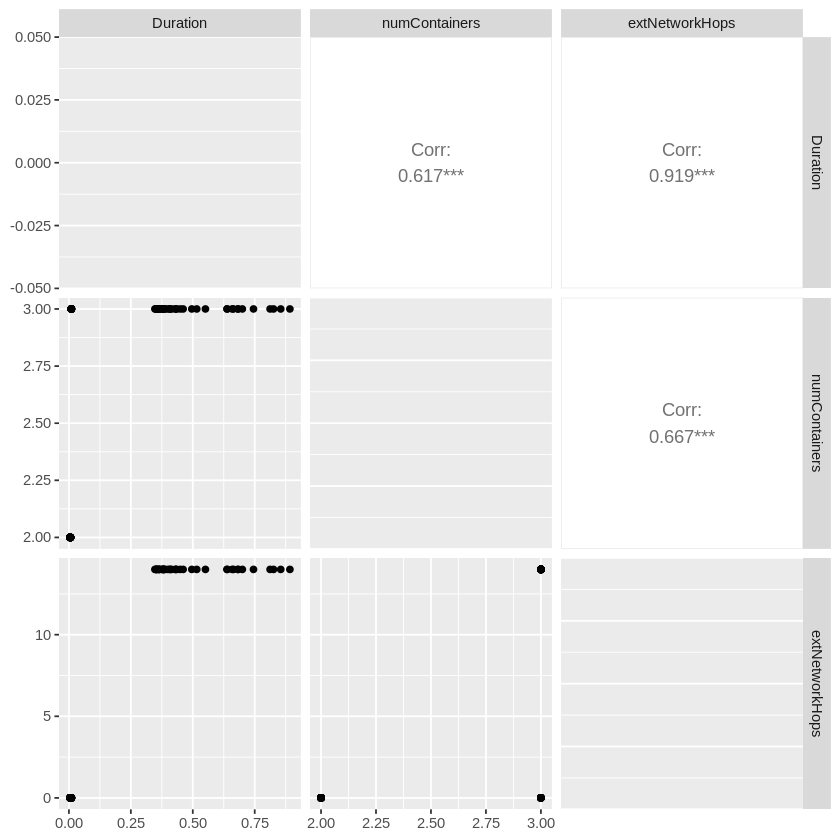

In [10]:
spanMetrics %>%
    select(Duration, numContainers, extNetworkHops) %>%
    ggpairs(spanMetrics)

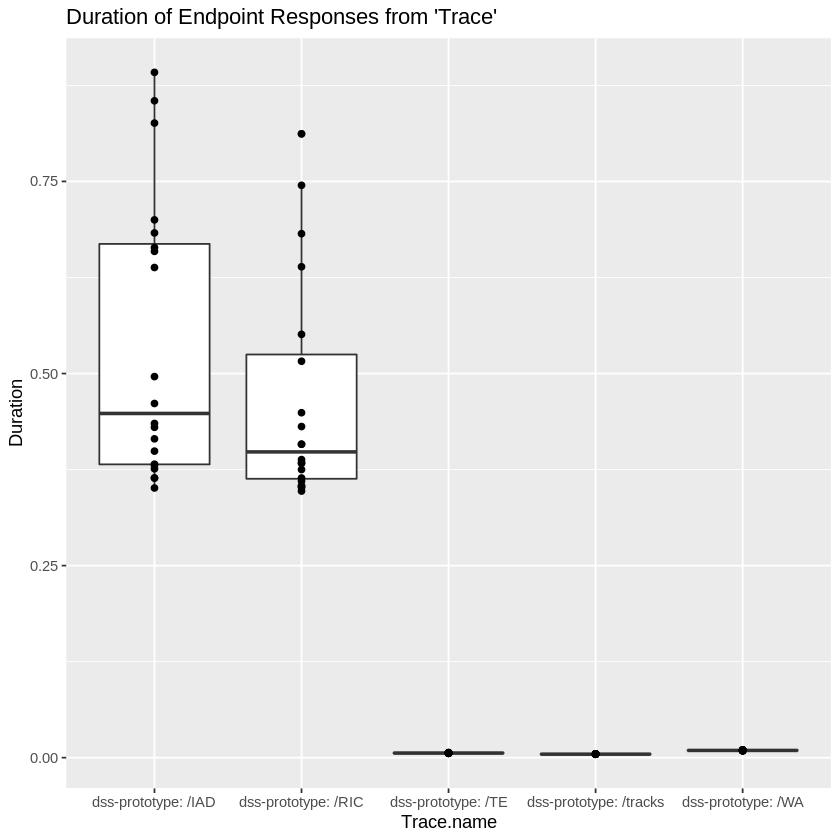

In [11]:
spanMetrics %>%
    ggplot(aes(Trace.name, Duration)) + 
    geom_boxplot() + geom_point() +
    ggtitle("Duration of Endpoint Responses from 'Trace'")

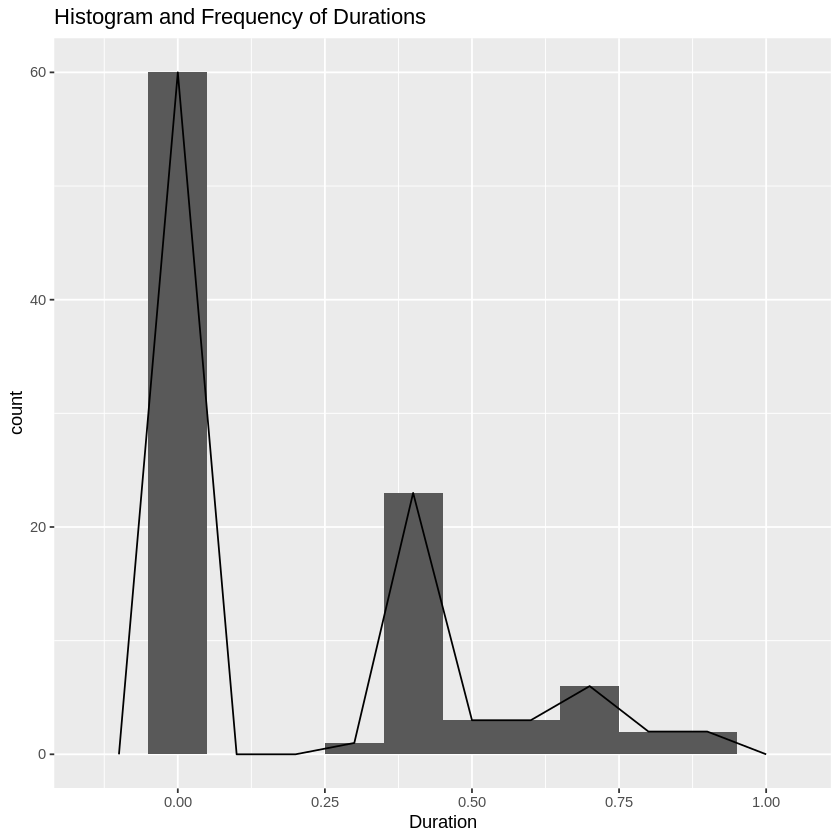

In [12]:
spanMetrics %>%
    ggplot(aes(Duration)) + 
    geom_histogram(binwidth = 0.1) + 
    geom_freqpoly(binwidth = 0.1) +
    ggtitle("Histogram and Frequency of Durations")

### Q-Q Normality Test ###

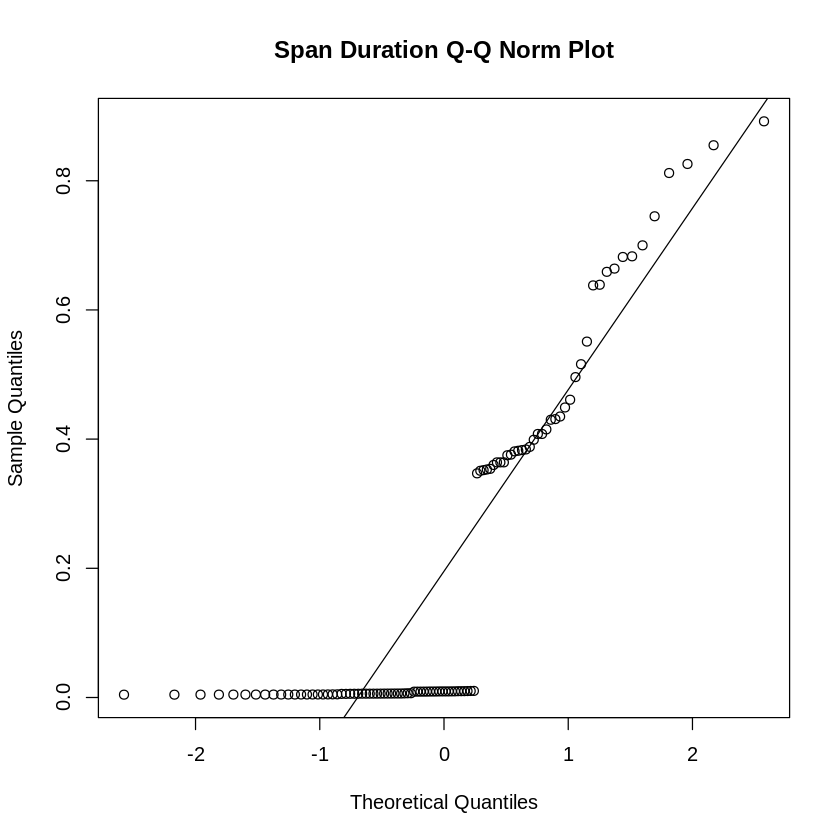

In [13]:
qqnorm(spanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
qqline(spanMetrics$Duration)

A transformation is needed to apply statistical analysis.

## Clean the Data ##

### Search for Outliers ###

In [21]:
# Use this to get the values of the statistical outliers in trk_update_data from R
outliers <- boxplot(spanMetrics$Duration, plot = FALSE)$out
outliers

cleanMetrics <- spanMetrics
# cleanMetrics <- cleanMetrics[-which(cleanMetrics$Duration %in% outliers),]

numeric(0)

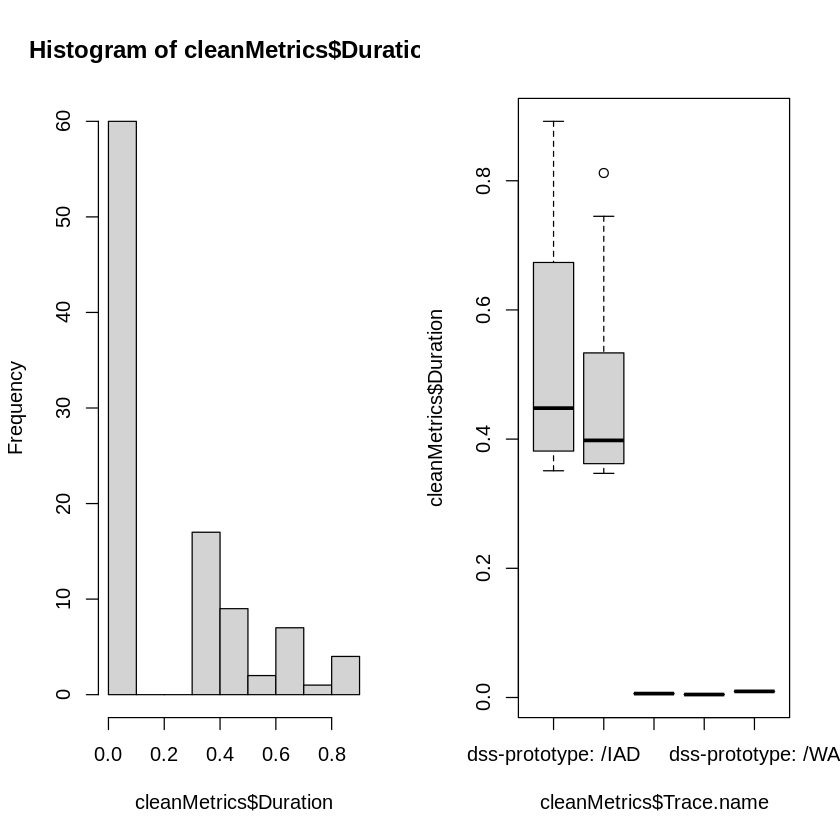

In [22]:
par(mfrow=c(1,2))
hist(cleanMetrics$Duration)
boxplot(cleanMetrics$Duration~cleanMetrics$Trace.name)

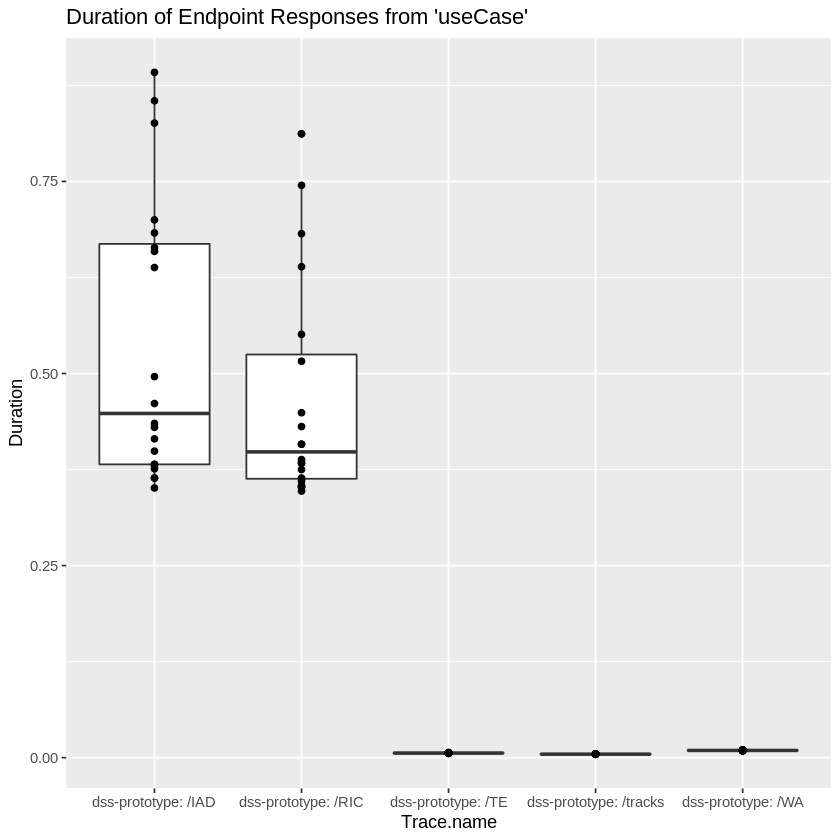

In [23]:
cleanMetrics %>%
    ggplot(aes(Trace.name, Duration)) + 
    geom_boxplot() + geom_point() +
    ggtitle("Duration of Endpoint Responses from 'useCase'")

### Transformation of Clean Metrics ###

#### Sqrt, Log, and Cube Transformations ####

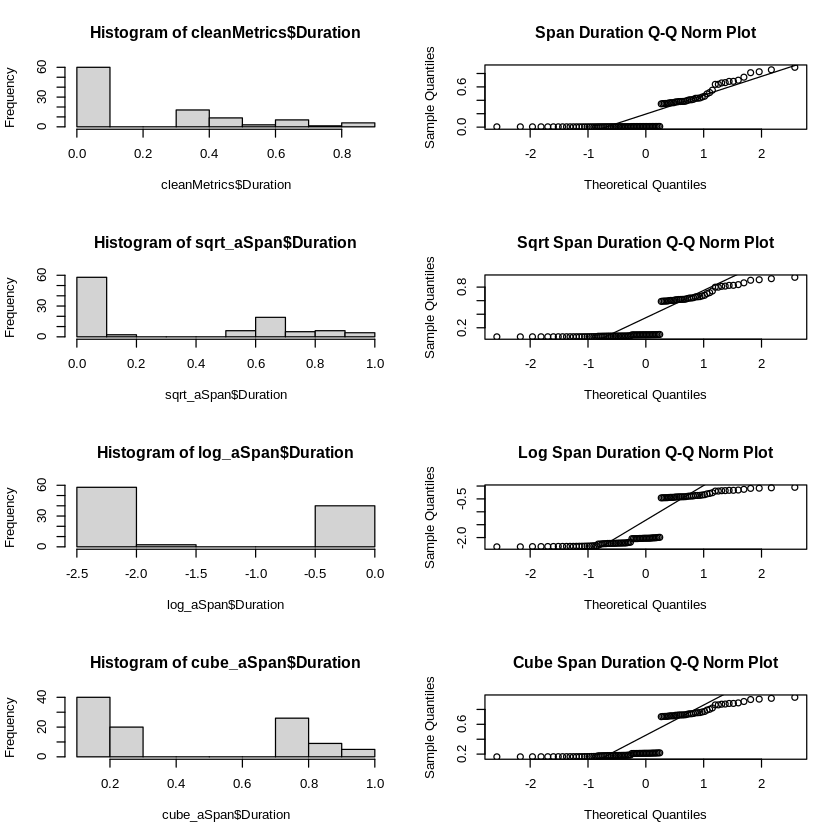

In [24]:
sqrt_aSpan <- cleanMetrics
sqrt_aSpan$Duration=sqrt(sqrt_aSpan$Duration)
log_aSpan <- cleanMetrics
log_aSpan$Duration=log10(log_aSpan$Duration)
cube_aSpan <- cleanMetrics
cube_aSpan$Duration=cube_aSpan$Duration^(1/3)

par(mfrow=c(4,2))
hist(cleanMetrics$Duration)
qqnorm(cleanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
qqline(cleanMetrics$Duration)
hist(sqrt_aSpan$Duration)
qqnorm(sqrt_aSpan$Duration,main="Sqrt Span Duration Q-Q Norm Plot")
qqline(sqrt_aSpan$Duration)
hist(log_aSpan$Duration)
qqnorm(log_aSpan$Duration,main="Log Span Duration Q-Q Norm Plot")
qqline(log_aSpan$Duration)
hist(cube_aSpan$Duration)
qqnorm(cube_aSpan$Duration,main="Cube Span Duration Q-Q Norm Plot")
qqline(cube_aSpan$Duration)

None of these transformation yield distributions that would be considered normal. Most likely due to access to external and internal services with differing latency. Let try another transformation. 

#### Box-Cox Transformation ####

Box and Cox (1964) developed a family of transformations designed to reduce nonnormality of the errors in a linear model. Applying this transform often reduces non-linearity as well, and heteroscedascity.

The idea is to transform the response variable $Y$ to a replacement response variable $Y_i^{(\lambda)}$, leaving the right-hand side of the regression model unchanged, so that the regression residuals become normally-distributed. Note that the regression coefficients will also change, because the response variable has changed; therefore, the regression coefficients must be interpreted with respect to the transformed variable. Also, any predictions made with the model have to be back-transformed, to be interpreted in the original units.

The standard (simple) Box-Cox transform is:

$$
    Y_i^{(\lambda)}=
\begin{cases}
{\frac {Y_i^\lambda - 1} \lambda},  & {(\lambda \neq 0)} \\
log(Y_i), & {(\lambda = 0)}
\end{cases}
$$

_Box, G. E. P., & Cox, D. R. (1964). An Analysis of Transformations. Journal of the Royal Statistical Society, Series B (Metholodogical), 26(2), 211-252._

http://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/Transformations.html

In [25]:
library(MASS)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




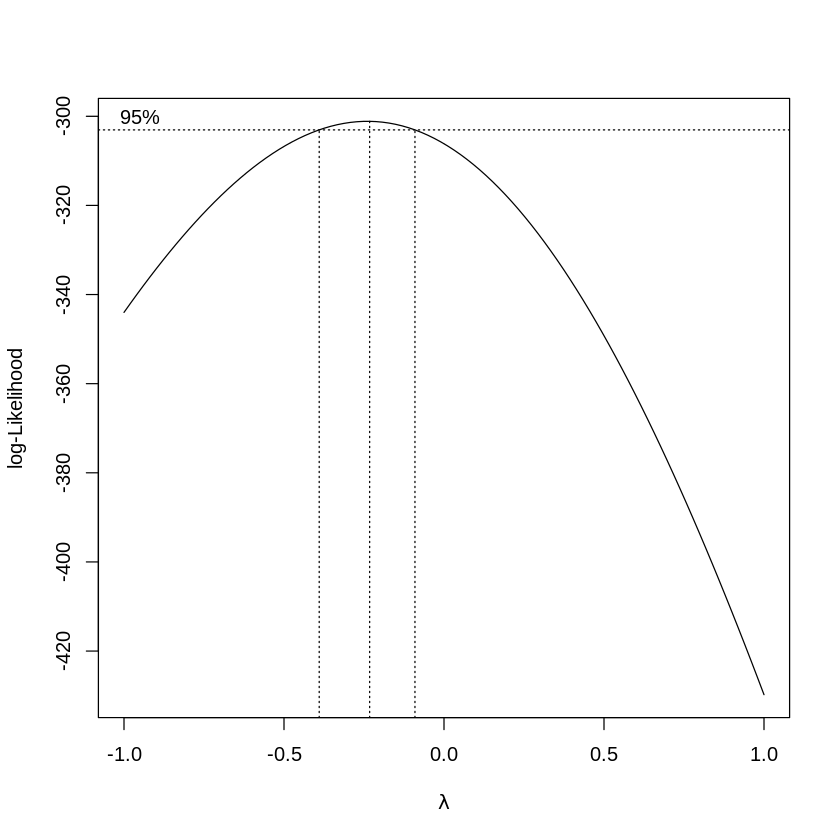

In [26]:
bcData = cleanMetrics
x <- bcData$Duration
bc = boxcox(lm(x ~ 1), seq(-1,1,.1))
#bc = boxcox(lm(x ~ 1))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

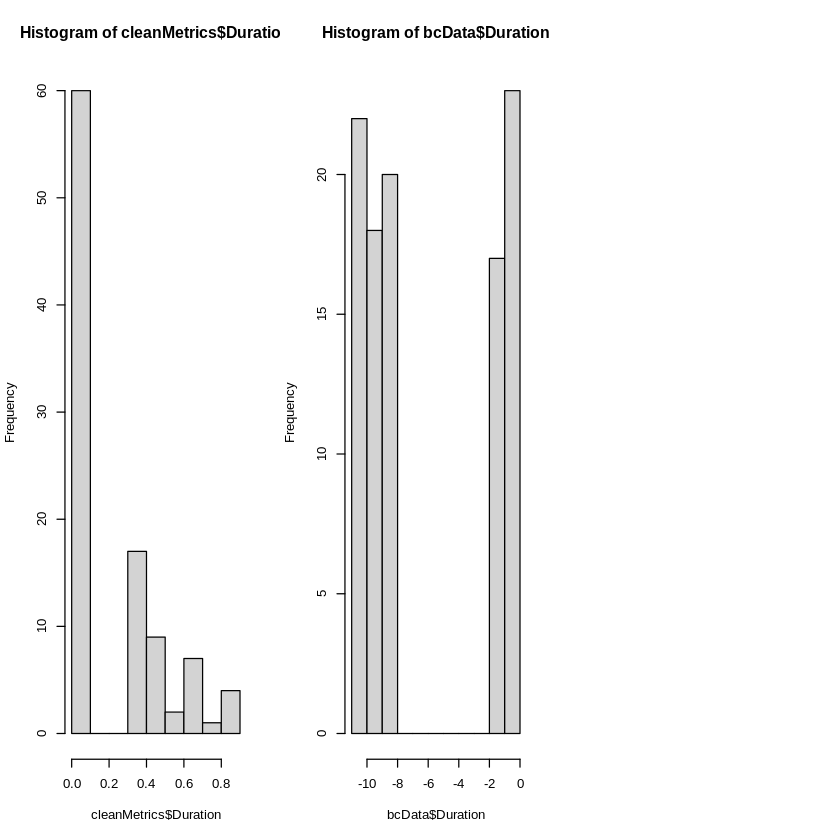

In [27]:
bcData$Duration = new_x_exact
par(mfrow=c(1,3))
hist(cleanMetrics$Duration)
hist(bcData$Duration)

### Normality Testing of the Trasformation ###

#### Shapiro-Wilk ####

The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population).

https://en.wikipedia.org/wiki/Shapiro–Wilk_test

In [28]:
shapiro.test(bcData$Duration)


	Shapiro-Wilk normality test

data:  bcData$Duration
W = 0.75596, p-value = 1.35e-11


With p-value of 2.852e-08 < 0.05 we reject the null hypothesis that the data are from a normally distributed population. But we'll also do a Q-Q Norm plot to visually see the results.

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

#### Q-Q Norm ####

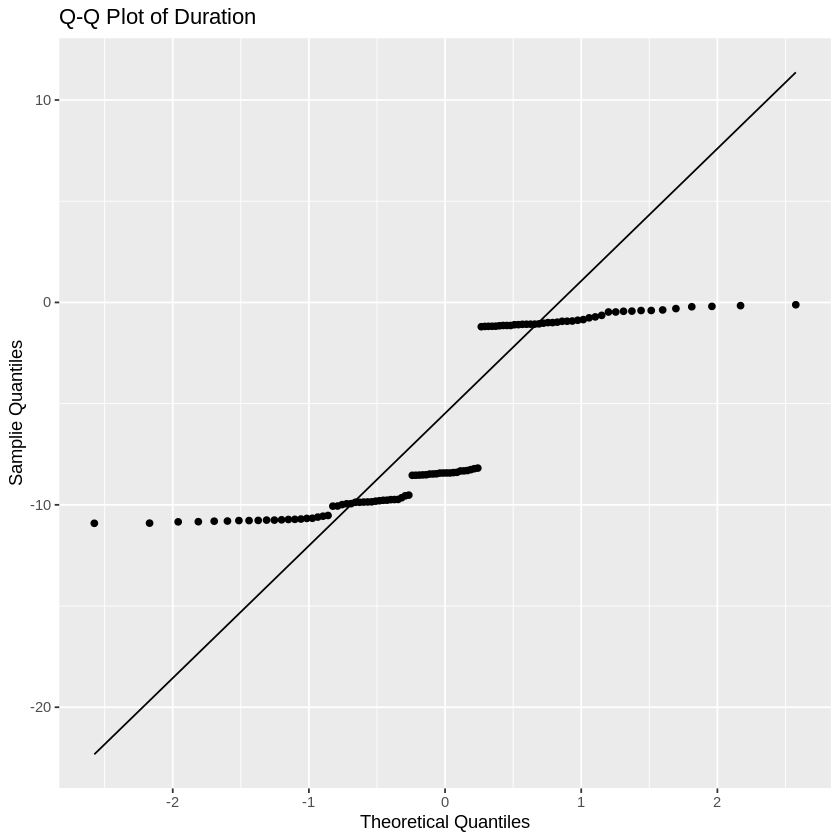

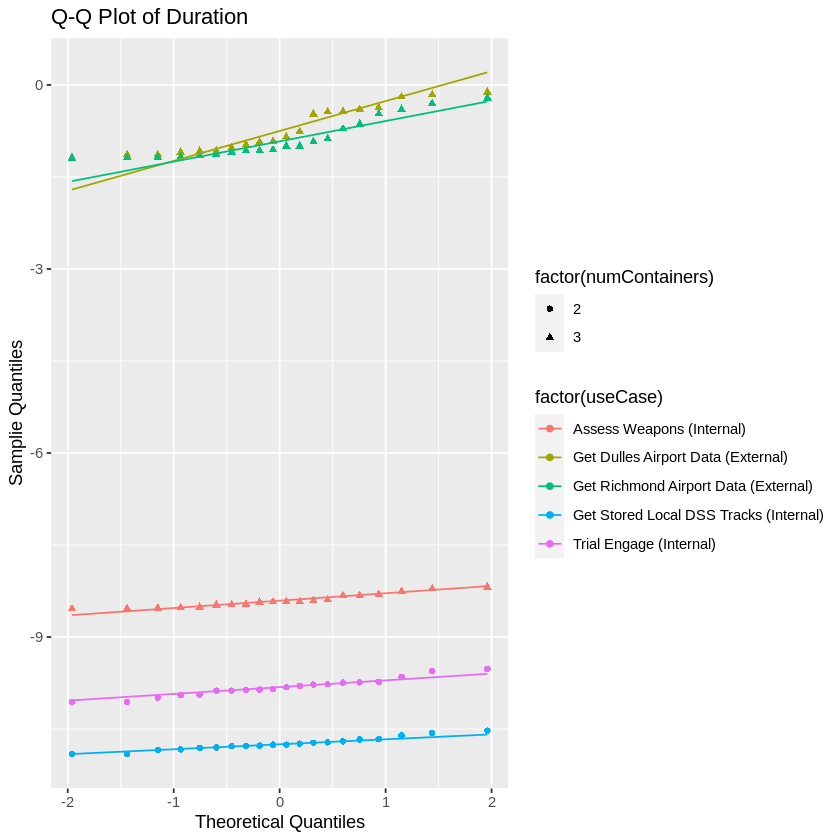

In [29]:
bcData %>%
    ggplot(aes(sample = Duration)) +
    stat_qq() +
    stat_qq_line() +
    labs(title="Q-Q Plot of Duration",
       x = "Theoretical Quantiles", y = "Samplie Quantiles")

bcData %>%
    ggplot(aes(sample = Duration, colour = factor(useCase), shape = factor(numContainers))) +
    stat_qq() +
    stat_qq_line() +
    labs(title="Q-Q Plot of Duration",
       x = "Theoretical Quantiles", y = "Samplie Quantiles")

Our assumption here is that the separation of **Sample Quantiles** is from the difference between internal and external span durations (e.g. latency). Let's see what happens when we split the samples.

## Separating "Original" Internal from External Data ##

### Internal Data ###

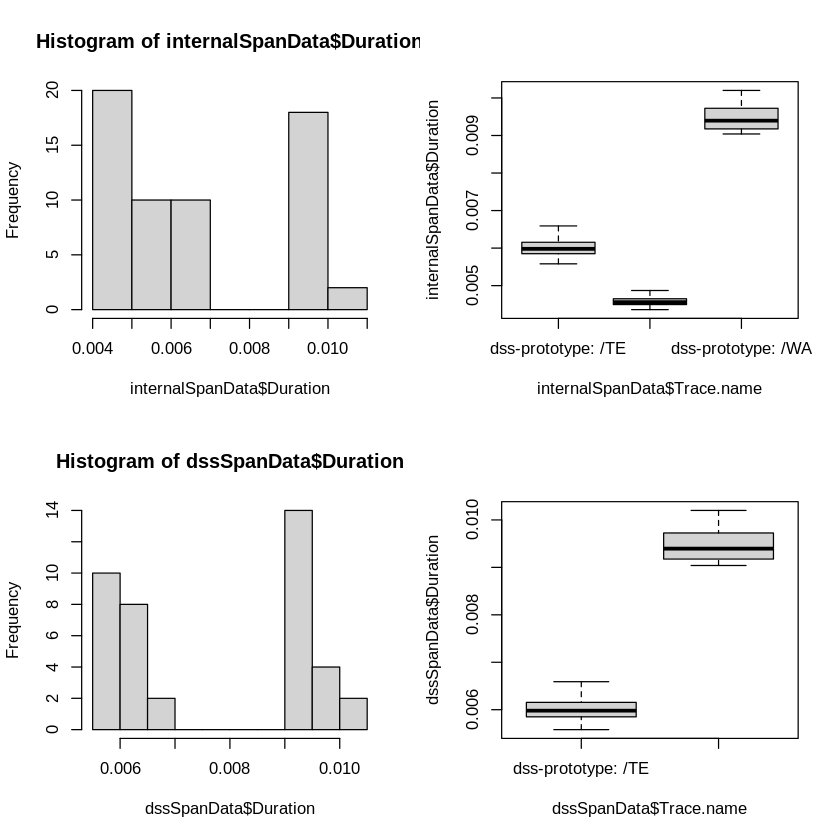

In [30]:
tracksSpanData = subset(spanMetrics, Trace.name == "dss-prototype: /tracks")
TE_SpanData = subset(spanMetrics, Trace.name == "dss-prototype: /TE")
WA_SpanData = subset(spanMetrics, Trace.name == "dss-prototype: /WA")

internalSpanData <- rbind(tracksSpanData, TE_SpanData, WA_SpanData)
dssSpanData <- rbind(TE_SpanData, WA_SpanData)

# head(tracksSpanData)
# head(TE_SpanData)
# head(WA_SpanData)
# head(internalSpanData)

par(mfrow=c(2,2))
hist(internalSpanData$Duration)
boxplot(internalSpanData$Duration~internalSpanData$Trace.name)
hist(dssSpanData$Duration)
boxplot(dssSpanData$Duration~dssSpanData$Trace.name)

This result looks much better.  However, we'll remove internal span outliers.

numeric(0)

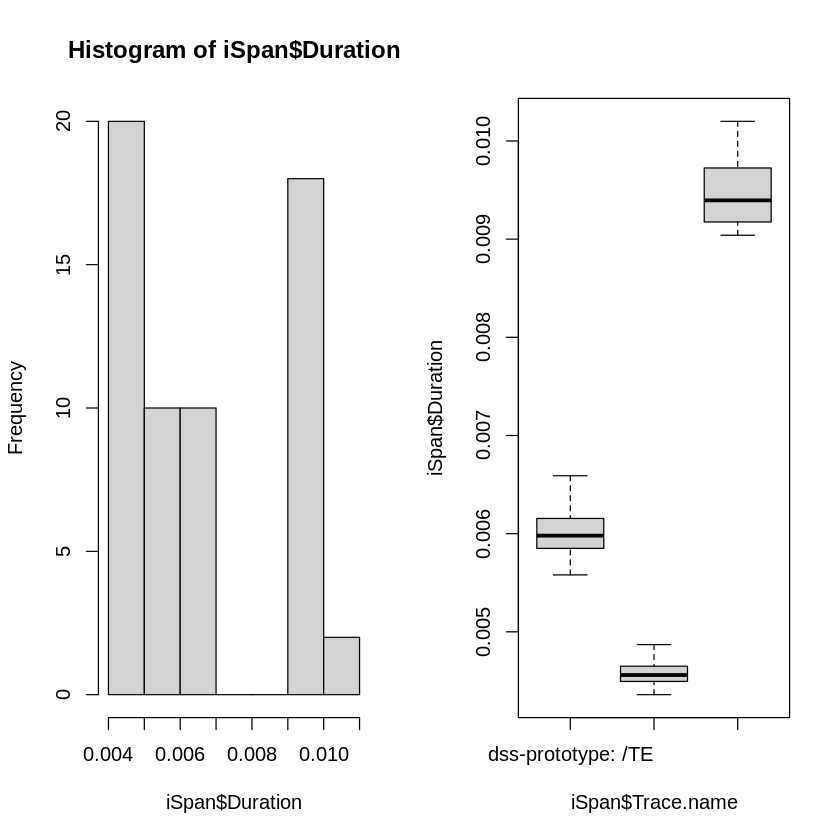

In [32]:
outliers <- boxplot(internalSpanData$Duration, plot = FALSE)$out
outliers

iSpan <- internalSpanData
# iSpan <- iSpan[-which(iSpan$Duration %in% outliers),]

par(mfrow=c(1,2))
hist(iSpan$Duration)
boxplot(iSpan$Duration~iSpan$Trace.name)

#### Q-Q Norm Plot of "Clean" Internal Span Data ####

We'll look a the Q-Q Norm Plot and Shapiro-Wilk Test

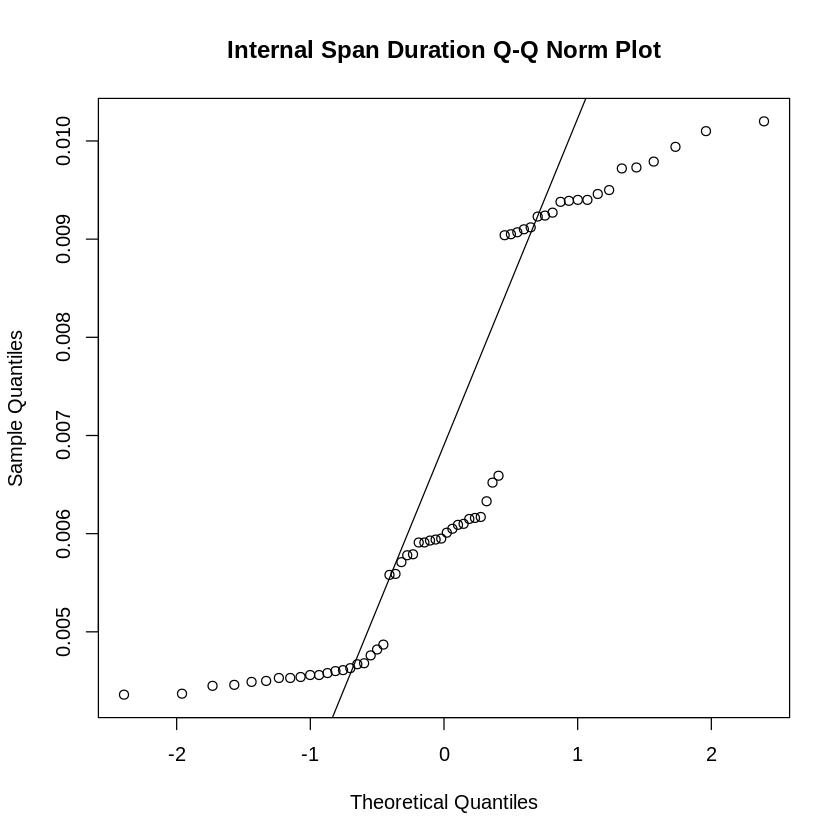

In [33]:
qqnorm(iSpan$Duration, main="Internal Span Duration Q-Q Norm Plot")
qqline(iSpan$Duration)

#### Autocorrelation ####

Autocorrelation plots are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

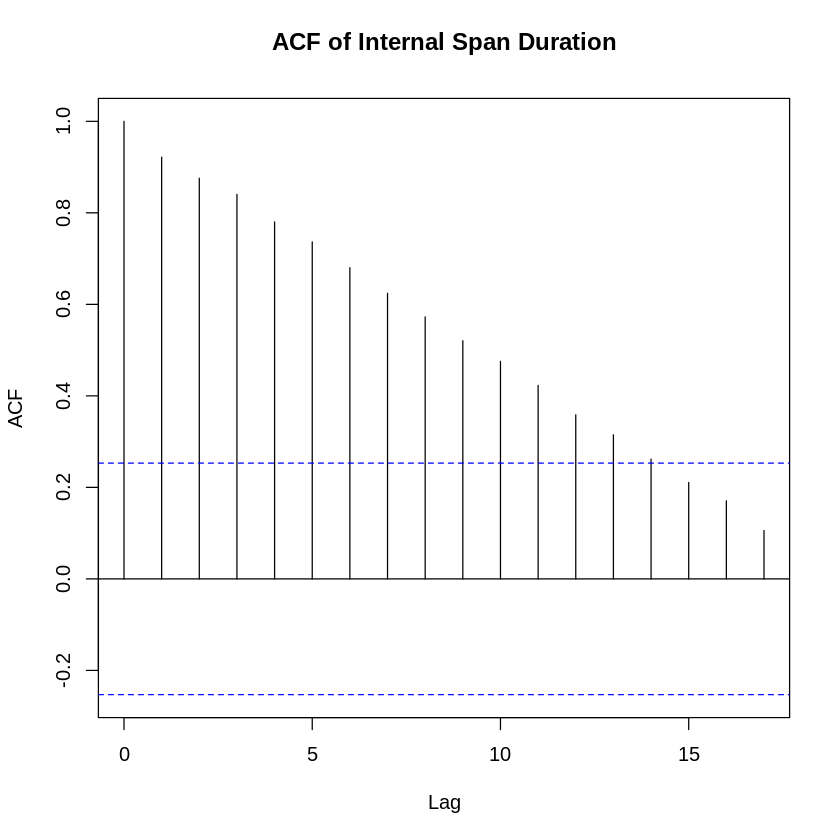

In [34]:
acf(iSpan$Duration, main="ACF of Internal Span Duration")

#### Shapiro-Wilk Normality Test ####

In [35]:
shapiro.test(iSpan$Duration)


	Shapiro-Wilk normality test

data:  iSpan$Duration
W = 0.82504, p-value = 6.023e-07


With p-value of 0.002321 < 0.05 we reject the null hypothesis that the data are from a normally distributed population. 

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

#### Data Transformations ####

##### Sqrt-Log-Cube Transformations #####

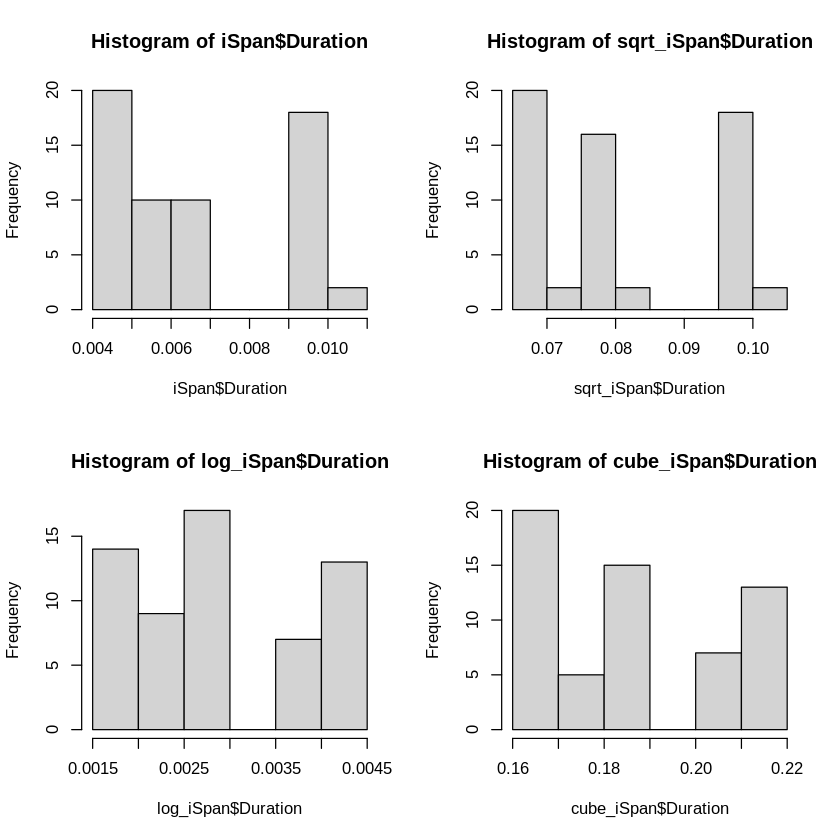

In [36]:
sqrt_iSpan <- iSpan
sqrt_iSpan$Duration=sqrt(sqrt_iSpan$Duration)
log_iSpan <- iSpan
log_iSpan$Duration=log10(log_iSpan$Duration + 1)
cube_iSpan <- iSpan
cube_iSpan$Duration=cube_iSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(iSpan$Duration)
hist(sqrt_iSpan$Duration)
hist(log_iSpan$Duration)
hist(cube_iSpan$Duration)

##### Q-Q Norm Sqrt-Log-Cube #####

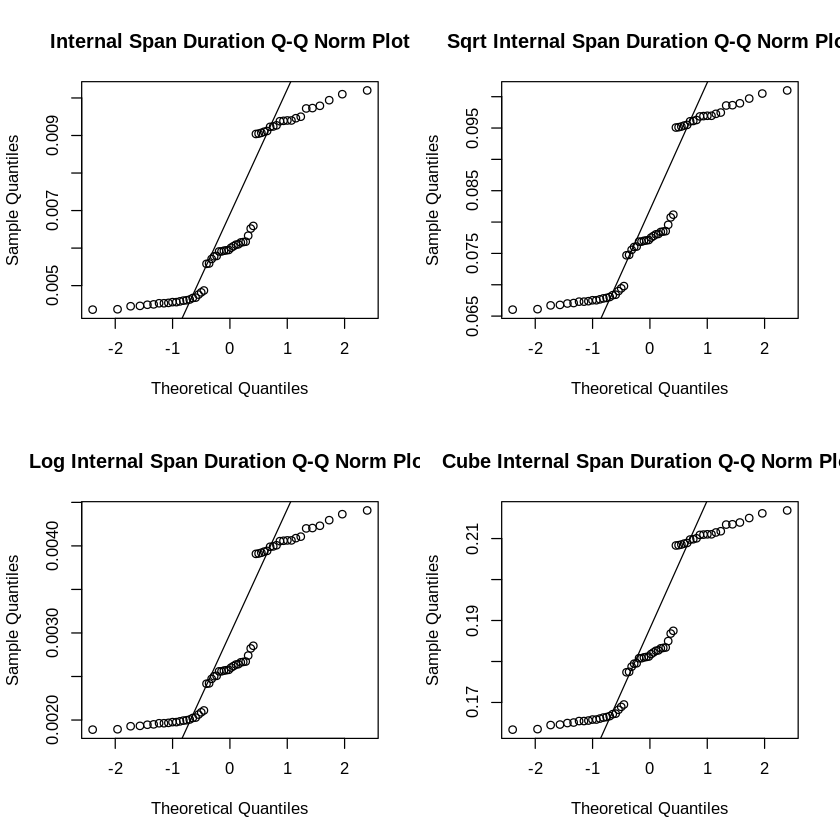

In [37]:
par(mfrow=c(2,2))
qqnorm(iSpan$Duration,main="Internal Span Duration Q-Q Norm Plot")
qqline(iSpan$Duration)
qqnorm(sqrt_iSpan$Duration,main="Sqrt Internal Span Duration Q-Q Norm Plot")
qqline(sqrt_iSpan$Duration)
qqnorm(log_iSpan$Duration,main="Log Internal Span Duration Q-Q Norm Plot")
qqline(log_iSpan$Duration)
qqnorm(cube_iSpan$Duration,main="Cube Internal Span Duration Q-Q Norm Plot")
qqline(cube_iSpan$Duration)

##### Shapiro-Wilk Testing Sqrt-Log-Cube #####

In [38]:
shapiro.test(sqrt_iSpan$Duration)
shapiro.test(log_iSpan$Duration)
shapiro.test(cube_iSpan$Duration)


	Shapiro-Wilk normality test

data:  sqrt_iSpan$Duration
W = 0.83845, p-value = 1.413e-06



	Shapiro-Wilk normality test

data:  log_iSpan$Duration
W = 0.82521, p-value = 6.085e-07



	Shapiro-Wilk normality test

data:  cube_iSpan$Duration
W = 0.84258, p-value = 1.852e-06


The **cube transformation** seems to provide the best q-q plot fit. With a p-value of 0.3593 > 0.05 we fail to reject the null hypothesis and assume we now have a normal distribution. 

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

<!-- #### Box-Cox Transformation #### -->

#### Autocorrelation ####

Autocorrelation plots are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

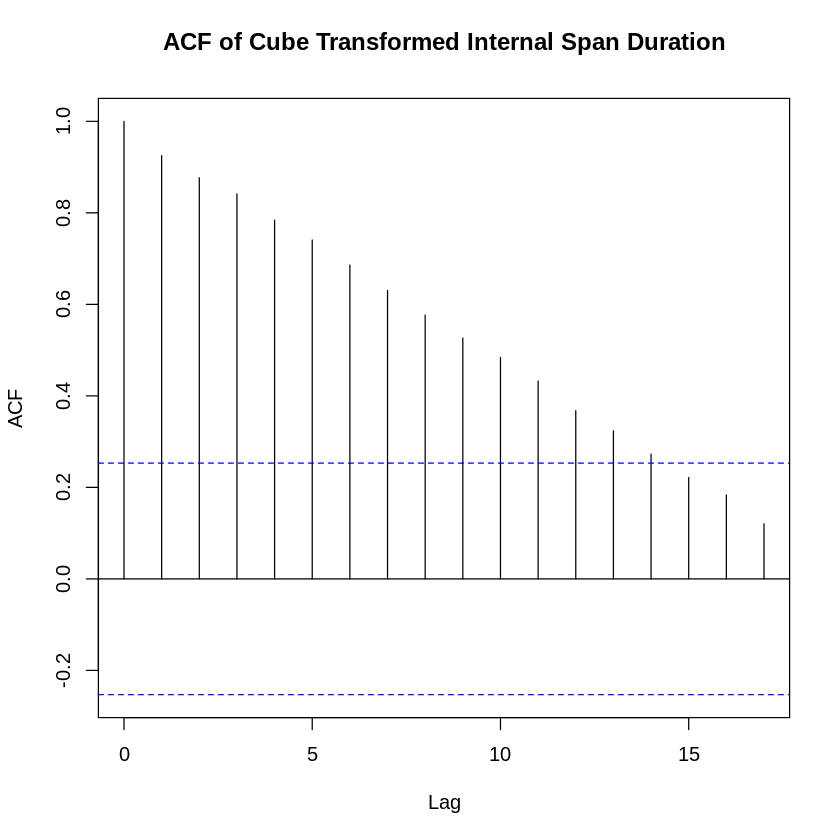

In [39]:
acf(cube_iSpan$Duration, main="ACF of Cube Transformed Internal Span Duration")

The ACF indicates that the data is random since the results are near zero.

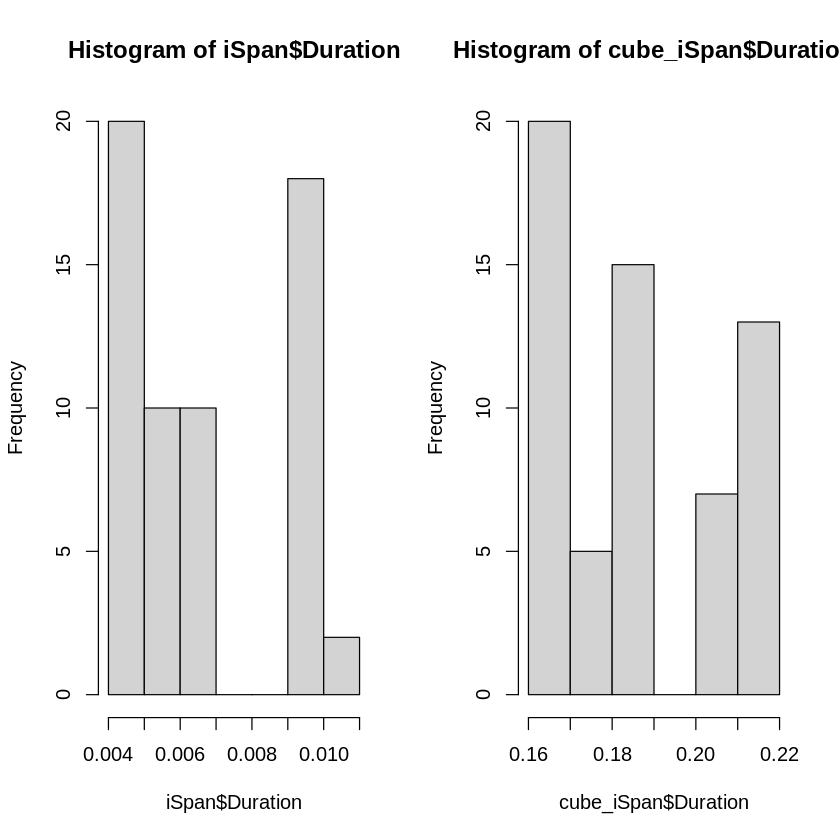

In [40]:
par(mfrow=c(1,2))
hist(iSpan$Duration)
hist(cube_iSpan$Duration)

<!-- With a Box-Cox transformation with a p-value of 0.05123 > 0.05 we fail to reject the null hypothesis, i.e. we assume that we now have a normal distribution. -->

#### Hypothesis Testing ####

We will use a Student's t-Test to test the hypothesis on **normal** internal span data. Our mean is 500 ms (e.g. $\mu = 0.5$ seconds) and our null hypthesis is less than 500 ms.

In [41]:
mu = 0.5
x = cube_iSpan$Duration
cube_mu = mu^(1/3)
t.test(x=x, mu=cube_mu, alternative = 'greater')


	One Sample t-test

data:  x
t = -246.02, df = 59, p-value = 1
alternative hypothesis: true mean is greater than 0.7937005
95 percent confidence interval:
 0.1823012       Inf
sample estimates:
mean of x 
0.1864261 


In [42]:
mu = 0.5
x = iSpan$Duration
t.test(x=x, mu=mu, alternative = 'greater')


	One Sample t-test

data:  x
t = -1836.4, df = 59, p-value = 1
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.006233764         Inf
sample estimates:
  mean of x 
0.006682667 


With a original and transformation with a p-value of 1 > 0.05 we fail to reject the null hypothesis, i.e. we assume that latency will be less than 500 ms.

_"If the p value is greater than the chosen alpha level, then the null hypothesis (that latency is < 500 ms) can not be rejected"_

### External Data ###

   Trace.ID          Trace.name          Start.time           Duration     
 Length:40          Length:40          Min.   :1.653e+09   Min.   :0.3470  
 Class :character   Class :character   1st Qu.:1.653e+09   1st Qu.:0.3757  
 Mode  :character   Mode  :character   Median :1.653e+09   Median :0.4225  
                                       Mean   :1.653e+09   Mean   :0.5018  
                                       3rd Qu.:1.653e+09   3rd Qu.:0.6440  
                                       Max.   :1.653e+09   Max.   :0.8920  
   useCase          numContainers extNetworkHops
 Length:40          Min.   :3     Min.   :14    
 Class :character   1st Qu.:3     1st Qu.:14    
 Mode  :character   Median :3     Median :14    
                    Mean   :3     Mean   :14    
                    3rd Qu.:3     3rd Qu.:14    
                    Max.   :3     Max.   :14    

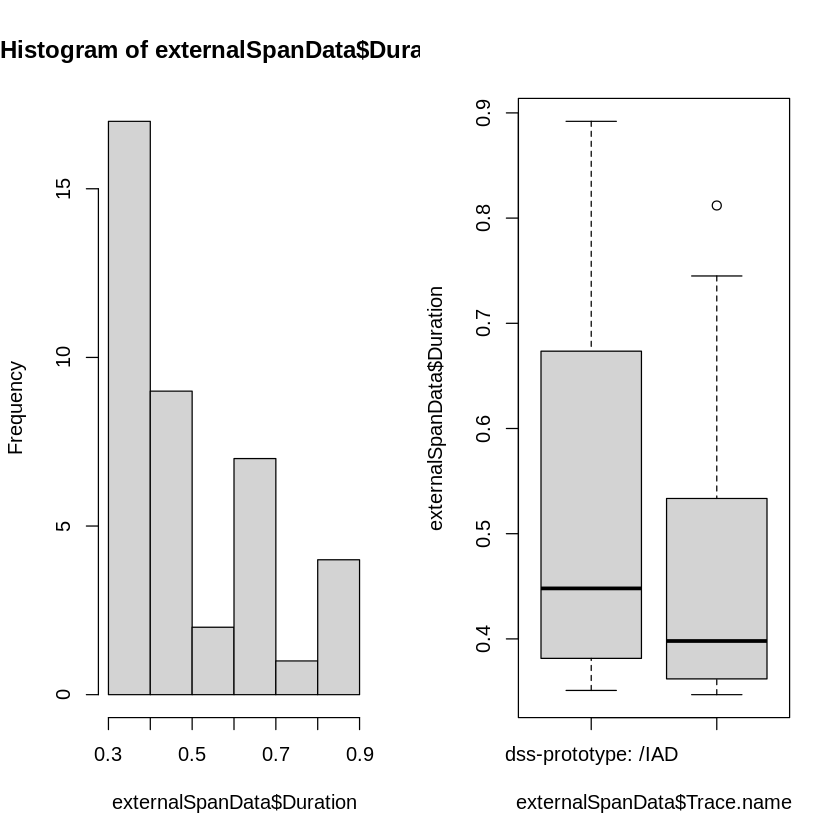

In [43]:
RIC_SpanData = subset(spanMetrics, Trace.name == "dss-prototype: /RIC")
IAD_SpanData = subset(spanMetrics, Trace.name == "dss-prototype: /IAD")

externalSpanData <- rbind(RIC_SpanData, IAD_SpanData)

# head(RIC_SpanData)
# head(IAD_SpanData)

summary(externalSpanData)

par(mfrow=c(1,2))
hist(externalSpanData$Duration)
boxplot(externalSpanData$Duration~externalSpanData$Trace.name)

numeric(0)

   Trace.ID          Trace.name          Start.time           Duration     
 Length:40          Length:40          Min.   :1.653e+09   Min.   :0.3470  
 Class :character   Class :character   1st Qu.:1.653e+09   1st Qu.:0.3757  
 Mode  :character   Mode  :character   Median :1.653e+09   Median :0.4225  
                                       Mean   :1.653e+09   Mean   :0.5018  
                                       3rd Qu.:1.653e+09   3rd Qu.:0.6440  
                                       Max.   :1.653e+09   Max.   :0.8920  
   useCase          numContainers extNetworkHops
 Length:40          Min.   :3     Min.   :14    
 Class :character   1st Qu.:3     1st Qu.:14    
 Mode  :character   Median :3     Median :14    
                    Mean   :3     Mean   :14    
                    3rd Qu.:3     3rd Qu.:14    
                    Max.   :3     Max.   :14    

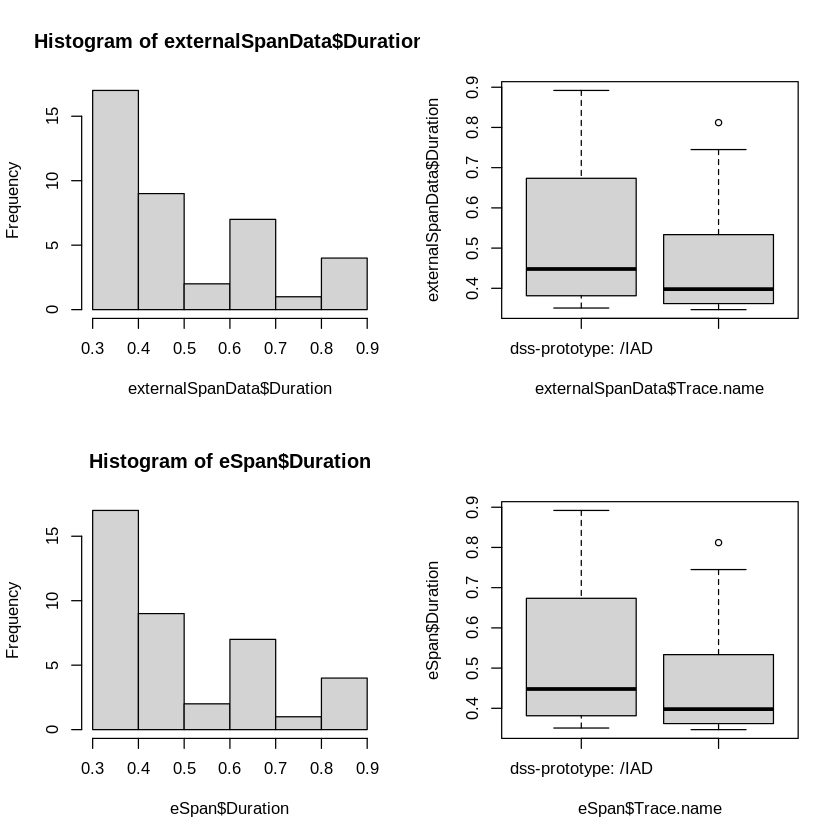

In [48]:
outliers <- boxplot(externalSpanData$Duration, plot = FALSE)$out
outliers

eSpan <- externalSpanData
# eSpan <- eSpan[-which(eSpan$Duration %in% outliers),]

summary(eSpan)

par(mfrow=c(2,2))
hist(externalSpanData$Duration)
boxplot(externalSpanData$Duration~externalSpanData$Trace.name)
hist(eSpan$Duration)
boxplot(eSpan$Duration~eSpan$Trace.name)

#### Q-Q Norm Plot of "Clean" External Span Data ####

We'll look a the Q-Q Norm Plot and Shapiro-Wilk Test

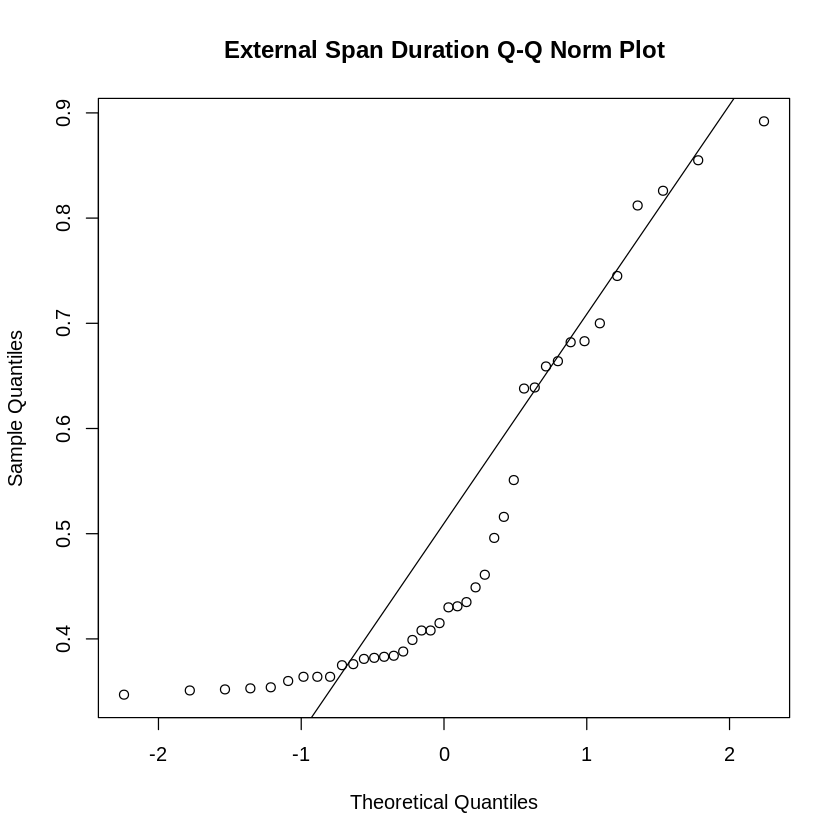

In [49]:
qqnorm(eSpan$Duration, main="External Span Duration Q-Q Norm Plot")
qqline(eSpan$Duration)

#### Shapiro-Wilk Normality Test ####

In [50]:
shapiro.test(eSpan$Duration)


	Shapiro-Wilk normality test

data:  eSpan$Duration
W = 0.81954, p-value = 1.777e-05


With a p-value of 0.2878 > 0.05 we fail to reject the null hypothesis, i.e. we assume that we have a normal distribution.



#### Autocorrelation ####

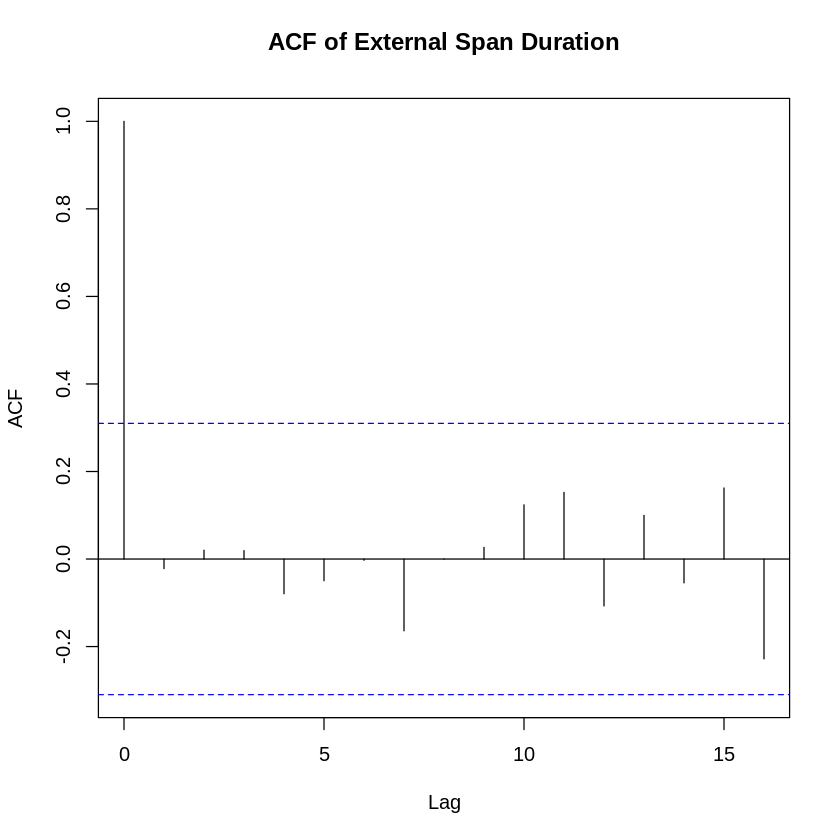

In [51]:
acf(eSpan$Duration, main="ACF of External Span Duration")

The ACF indicates that the data is random since the results are near zero.

<!-- The log transformation yields the best fit so we we shall use it moving forward.

The **log transformation** with a p-value of 0.1643 > 0.05. We now have a normal distribution. -->

#### Hypothesis Testing ####

We will use a Student's t-Test to test the hypothesis on external span data. Our mean is 500 ms (e.g. $\mu = 0.5$ seconds) and our null hypthesis is less than 500 ms.

In [52]:
mu = 0.5

In [53]:
x = eSpan$Duration
t.test(x=x, mu=mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 0.068414, df = 39, p-value = 0.4729
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.4574701       Inf
sample estimates:
mean of x 
   0.5018 


With a p-value of 0.1336 > 0.05 we fail to reject the null hypothesis, i.e. we assume that 500 ms can be maintained for external service requests.

_"If the p value is greater than the chosen alpha level, then the null hypothesis (that latency is < 500 ms) can not be rejected"_

## Observations ##

### General Discussion of Normality ###
It was required to separate external data from internal to establish normality of the data samples. The internal data set required transformation to establish normality, while the external data did not require a transformation. 

### Hypothesis Results ###

Hypothesis testing using the Student's t-Test indicates that latency constraints of 500 ms can be maintained internally and external. However, serveral external samples were greater than 500 ms. This is most likely due to the non-deterministic nature of internet (e.g. http) requests. Within the internal environment, data is directly routed between microservices within the Docker environment within a private network. The data shows that a container based microservice architecture can meet the requirement; however, care must be taken to manage processing per container that may increase container response times.